In [1]:
from astropy.io import fits #astropy modules for FITS IO
import numpy as np #numpy gives us better array management 
from scipy import interpolate #spline interpolation
import os #checking status of requested files

In [2]:
import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting
import matplotlib.pyplot as plt
#next line is to show plots inline with jupyter
#%matplotlib inline 
from matplotlib.colors import LogNorm #for better display of FITS images

In [3]:
%matplotlib inline

In [4]:
import spgen as spgen #Python Routines for SpecGen Routines

In [5]:
# For Debuging
import importlib

In [6]:
importlib.reload(spgen) 

<module 'spgen' from '/Users/albert/Space/udm/NIRISS/github/jwst-mtl/SOSS/specgen/spgen.py'>

## Notebook Parameters  
These parameters set up the work environment.

In [7]:
workdir='/Users/albert/NIRISS/SOSSpipeline/sandbox/' #root folder for local files

## Model Parameters

In [8]:
pars=spgen.ModelPars()              #Set up default parameters
filename=workdir+'simpars.txt'      #location of file for parameter import 
pars=spgen.read_pars(filename,pars) #read in parameter file

## Get Instrument Response 

In [9]:
response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
reponse_ld,reponse_n0,reponse_n1,reponse_n2,reponse_n3,quantum_yield=spgen.readresponse(response_file)

## Read in Stellar Atmosphere

In [10]:
starmodel_wv,starmodel_flux=spgen.readstarmodel(workdir+pars.modelfile,pars.nmodeltype)

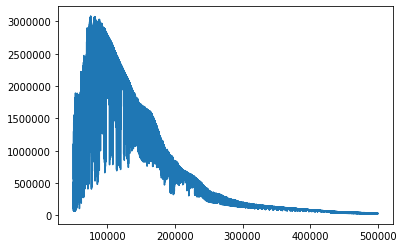

In [11]:
plt.plot(starmodel_wv,starmodel_flux)
plt.show()

Vega


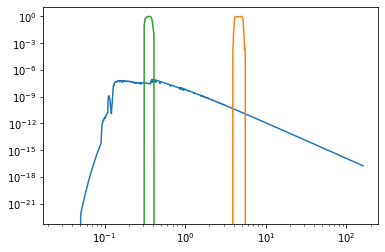

In [12]:
import synthesizeMagnitude as smag
pathvega = '/Users/albert/NIRISS/SOSSpipeline/sandbox/'
pathfilter = '/Users/albert/NIRISS/SOSSpipeline/sandbox/filterSVO/'
# example to use readVega
w,flambda = smag.readVega(path_vega_spectrum=pathvega)
plt.loglog(w,flambda)
# example to use readFilter
w,t,system = smag.readFilter('W2',path_filter_transmission=pathfilter)
print(system)
plt.plot(w,t)
w,t,system = smag.readFilter('Johnson-U',path_filter_transmission=pathfilter)
plt.plot(w,t)
plt.show()

Beginning of example_1
WISE2 magnitude of input spectrum: -38.20
To be normalized at magnitude  15.00


/Users/albert/Space/udm/NIRISS/github/jwst-mtl/SOSS/specgen/synthesizeMagnitude.py:138: RuntimeWarning: invalid value encountered in double_scalars
  Energy_Vega = np.sum(Flambda_Vega * filter_t) / np.sum(filter_t)
/Users/albert/Space/udm/NIRISS/github/jwst-mtl/SOSS/specgen/synthesizeMagnitude.py:139: RuntimeWarning: invalid value encountered in double_scalars
  Energy_filter = np.sum(Flba * filter_t) / np.sum(filter_t)


WISE2 magnitude of normalized spectrum:  15.00


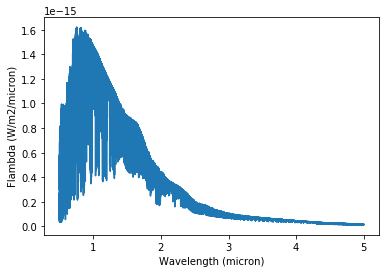

End of example_1
Beginning of example_2
KIC-r magnitude of uncalibrated spectrum:  -4.85
KIC-r magnitude of calibrated spectrum:   8.50


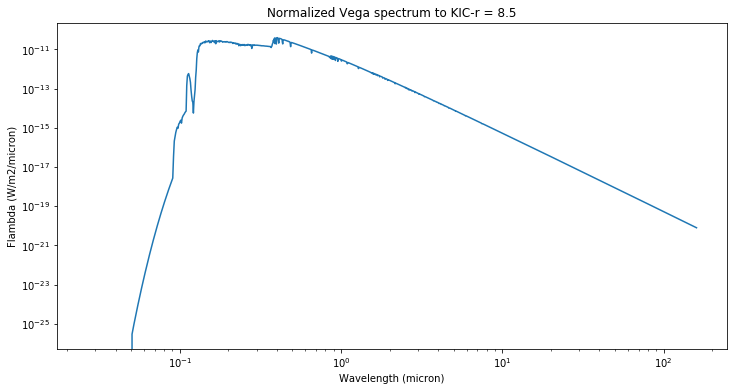

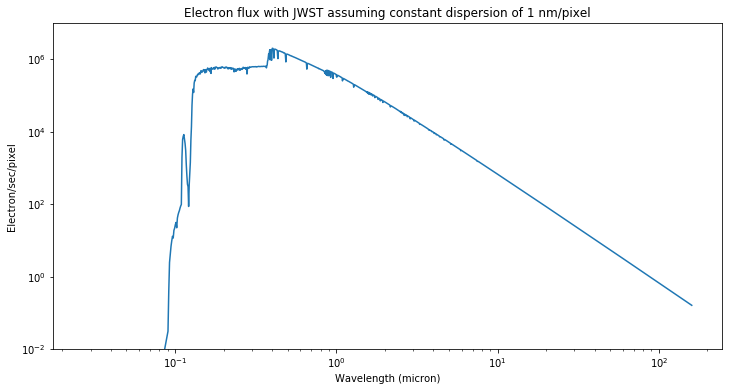

End of example_2


In [13]:
#Run example_1
# Massage input to example 1
#
# convert wavelengths to micrometers
wave_micron = starmodel_wv / 100000.
# expected flux is in Flambda, not Fnu. Won't be correct if Fnu.
# The exact units of Flambda is not important since it will be rescaled anyway.
flux_W_m2_micron = starmodel_flux * 1.0
#
# Run example_1
flux_normalized = smag.example_1(wave_micron, flux_W_m2_micron)
#
#Run example_2
electrons = smag.example_2()

# Example 3
## a) Normalizing the spectrum to J=8.5

In [17]:
# This is the example closest to what we nee for the pipeline.
# It includes: 
# 1) normalizing the spectrum to a band magnitude
# 2) multiplying by the instrument throughput and quantum yield
# 3) Converting to electrons/sec/pixel assuming a constant dispersion per pixel (that assumption should be revisited
print('Beginning of example 3')

# convert wavelengths to micrometers
wave_micron = starmodel_wv / 100000.
# expected flux is in Flambda (energy/time/surface/wavelength), not Fnu (energy/time/surface/Frequency). 
# Won't be correct if Fnu.
# The exact units of Flambda is not important since it will be rescaled anyway.
flux_W_m2_micron = starmodel_flux * 1.0

# Synthesize magnitudes
filterlist = ['WISE2','Johnson-U','TESS','2MASS-J'] # keep as array, an array of name is expected
pathvega = '/Users/albert/NIRISS/SOSSpipeline/sandbox/'
pathfilter = '/Users/albert/NIRISS/SOSSpipeline/sandbox/filterSVO/'
    
filtermag = smag.syntMag(wave_micron,flux_W_m2_micron,filterlist,
                    path_filter_transmission=pathfilter,
                    path_vega_spectrum=pathvega)
# take index 0 to get the magnitude of the first filter
MKOJ = filtermag[2]
print('MKOJ magnitude of input spectrum: {:6.2f}'.format(MKOJ))
mag = 8.5
print('To be normalized at magnitude {:6.2f}'.format(mag))
# Set the MKOJ magnitude to 9.0
flux_normalized = flux_W_m2_micron * 10**(-0.4*(mag-MKOJ))
filtermag = smag.syntMag(wave_micron,flux_normalized,filterlist,
                    path_filter_transmission=pathfilter,
                    path_vega_spectrum=pathvega)
MKOJok = filtermag[2]
print('MKOJ magnitude of normalized spectrum: {:6.2f}'.format(MKOJok))


Beginning of example 3


/Users/albert/Space/udm/NIRISS/github/jwst-mtl/SOSS/specgen/synthesizeMagnitude.py:138: RuntimeWarning: invalid value encountered in double_scalars
  Energy_Vega = np.sum(Flambda_Vega * filter_t) / np.sum(filter_t)
/Users/albert/Space/udm/NIRISS/github/jwst-mtl/SOSS/specgen/synthesizeMagnitude.py:139: RuntimeWarning: invalid value encountered in double_scalars
  Energy_filter = np.sum(Flba * filter_t) / np.sum(filter_t)


MKOJ magnitude of input spectrum: -35.45
To be normalized at magnitude   8.50
MKOJ magnitude of normalized spectrum:   8.50


## b) Multiply by the Throughput in Order 1

/Users/albert/anaconda/envs/astroconda_clean/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


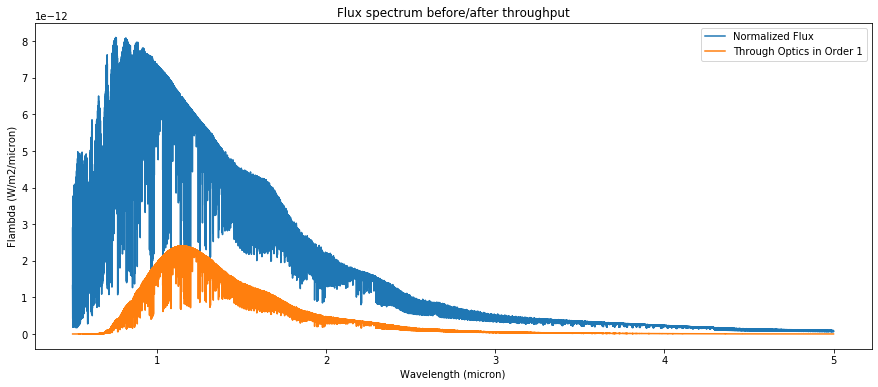

In [18]:
# Now consider the throughput loss:
#
# Here are the arrays read from the NIRISS_Throughput_STScI.fits calibration file
# reponse_ld,reponse_n0,reponse_n1,reponse_n2,reponse_n3,quantum_yield
# reponse_ld is the wavelength array (in ***angstroms***)
# reponse_n1 is the throughput of the first order (a fraction between 0 and 1)
#
# First, resample throughput curve in order 1 at the same wavelength as the spectrum
throughput_order1_resamp = np.interp(wave_micron,(reponse_ld/10000.),reponse_n1)

# Finally, the effective flambda flux making it through the optics is
flux_through = flux_normalized * throughput_order1_resamp

plt.figure(figsize=(15,6))
plt.title('Flux spectrum before/after throughput')
plt.plot(wave_micron,flux_normalized,label='Normalized Flux')
plt.plot(wave_micron,flux_through,label='Through Optics in Order 1')
plt.ylabel('Flambda (W/m2/micron)')
plt.xlabel('Wavelength (micron)')
plt.legend()
plt.show()

## c) Convert to electrons per second per spectral pixel, taking into account the Quantum Yield (a blue photon statistically producing more than 1 electron)

/Users/albert/anaconda/envs/astroconda_clean/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


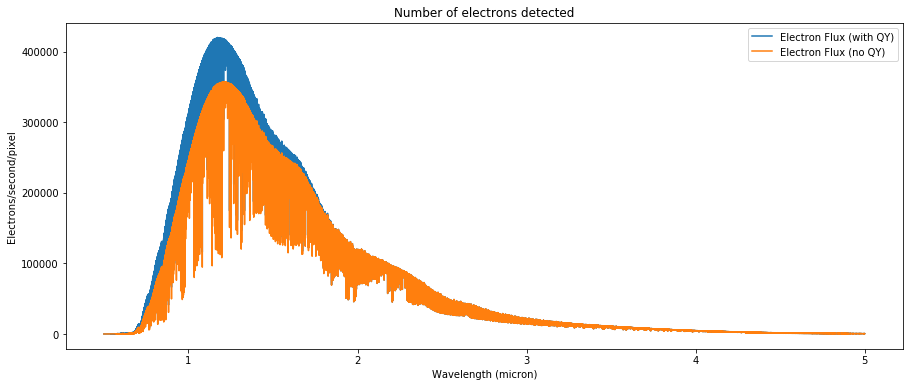

End of example 3


In [19]:
# Now, divide by the photon energy and integrate over 25 m2 (JWST) and by 
# the pixel dispersion (in microns per pixel: e.g. ~0.001 micron/pixel in SOSS m=1)
h = 6.62607004e-34 # m2 kg / sec
c = 299792458.0 #m/sec
photon_energy = h*c/(wave_micron*1e-6) # Joule
area = 25.0
# Dispersion in microns/pixel, could be an array matching the wave_micron
# dispersion_micron_pixel = some function from Geert Jan's library
dispersion_micron_pixel = 0.001

# Do the same for the quantum yield (a number equal to 1 or slightly larger at blue wavelengths)
# to account for more than 1 electron being produced by each photon impinging
quantum_yield_resamp = np.interp(wave_micron,(reponse_ld/10000.),quantum_yield)

# number of electrons per pixel ***per second per spectral pixel*** is:
nelectron_withoutQY = area * dispersion_micron_pixel * flux_through / photon_energy
nelectron_withQY = nelectron_withoutQY * quantum_yield_resamp

plt.figure(figsize=(15,6))
plt.title('Number of electrons detected')
plt.plot(wave_micron,nelectron_withQY,label='Electron Flux (with QY)')
plt.plot(wave_micron,nelectron_withoutQY,label='Electron Flux (no QY)')
plt.ylabel('Electrons/second/pixel')
plt.xlabel('Wavelength (micron)')
plt.legend()
plt.show()

    
print('End of example 3')